In [35]:
import os
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [40]:
uploaded = files.upload()

Saving part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv to part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000 (1).csv


In [41]:
dfs = []

for filename in uploaded.keys():
    df_temp = pd.read_csv(io.BytesIO(uploaded[filename]))
    print("Loaded:", filename, df_temp.shape)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print("Total Data Shape:", df.shape)

Loaded: part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000 (1).csv (238687, 47)
Total Data Shape: (238687, 47)


In [42]:
label_col = None
for col in df.columns:
    if "label" in col.lower():
        label_col = col
        break

if label_col is None:
    raise Exception("No label column found!")

print("Label column:", label_col)
print(df[label_col].value_counts())

Label column: label
label
DDoS-ICMP_Flood            36554
DDoS-UDP_Flood             27626
DDoS-TCP_Flood             23149
DDoS-PSHACK_Flood          21210
DDoS-SYN_Flood             20739
DDoS-RSTFINFlood           20669
DDoS-SynonymousIP_Flood    18189
DoS-UDP_Flood              16957
DoS-TCP_Flood              13630
DoS-SYN_Flood              10275
BenignTraffic               5600
Mirai-greeth_flood          5016
Mirai-udpplain              4661
Mirai-greip_flood           3758
DDoS-ICMP_Fragmentation     2377
MITM-ArpSpoofing            1614
DDoS-ACK_Fragmentation      1505
DDoS-UDP_Fragmentation      1484
DNS_Spoofing                 925
Recon-HostDiscovery          697
Recon-OSScan                 517
Recon-PortScan               430
DoS-HTTP_Flood               414
VulnerabilityScan            210
DDoS-HTTP_Flood              169
DDoS-SlowLoris               106
DictionaryBruteForce          63
SqlInjection                  31
BrowserHijacking              30
CommandInjection 

In [43]:
X = df.drop(columns=[label_col])
y = df[label_col]

# Convert labels to numbers
y = y.astype("category").cat.codes

# Keep numeric columns only
X = X.select_dtypes(include=[np.number])

# Remove inf and NaN
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

# Normalize
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.long).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.long).to(device)

# Add sequence dimension
X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)

Using device: cpu


In [46]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TransformerModel, self).__init__()

        self.embedding = nn.Linear(input_dim, 128)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            dim_feedforward=256,
            dropout=0.1,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=2
        )

        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [47]:
input_dim = X_train.shape[2]
num_classes = len(torch.unique(y_train))

model = TransformerModel(input_dim, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [48]:
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss:.4f}")

Epoch [1/10] Loss: 373.8397
Epoch [2/10] Loss: 325.2508
Epoch [3/10] Loss: 285.0867
Epoch [4/10] Loss: 207.2886
Epoch [5/10] Loss: 169.3235
Epoch [6/10] Loss: 157.2343
Epoch [7/10] Loss: 123.4239
Epoch [8/10] Loss: 125.8516
Epoch [9/10] Loss: 136.0865
Epoch [10/10] Loss: 108.7895


In [49]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds))

Accuracy: 0.9661904562403117

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.79      0.94      0.86      1118
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00         5
           4       0.99      0.97      0.98       311
           5       0.66      0.76      0.71        38
           6       1.00      1.00      1.00      7494
           7       0.98      0.95      0.96       494
           8       1.00      1.00      1.00      4175
           9       1.00      1.00      1.00      4072
          10       1.00      0.98      0.99      4248
          11       0.82      0.50      0.62        28
          12       1.00      1.00      1.00      3525
          13       1.00      0.99      0.99      4596
          14       0.98      1.00      0.99      5578
          15       0.91      0.97      0.94       309
          16       0.71    

In [50]:
torch.save(model.state_dict(), "best_model.pth")
print("Model saved successfully!")

Model saved successfully!


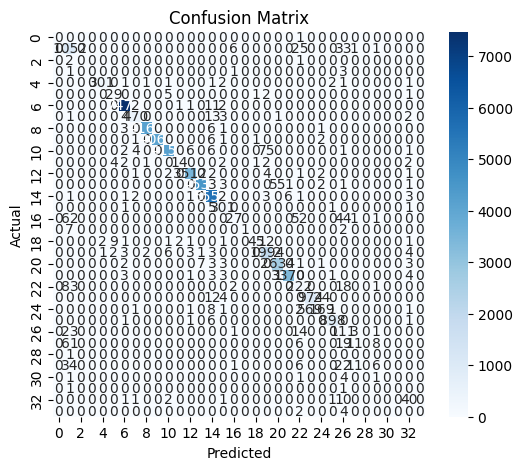

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [52]:
from sklearn.metrics import roc_curve, auc
import numpy as np

model.eval()
probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        probs.extend(probabilities[:,1].cpu().numpy())

fpr, tpr, _ = roc_curve(all_labels, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc:.4f})")
plt.show()

ValueError: multiclass format is not supported

In [53]:
class ImprovedTransformer(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ImprovedTransformer, self).__init__()

        self.embedding = nn.Linear(input_dim, 256)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=256,
            nhead=8,
            dim_feedforward=512,
            dropout=0.2,
            batch_first=True
        )

        self.transformer = nn.TransformerEncoder(
            encoder_layer,
            num_layers=3
        )

        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [54]:
model = ImprovedTransformer(input_dim, num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)

In [55]:
epochs = 20